# Modelagem de tópicos em arquivo de tweets

Script baseado em:
https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835

### Abre o arquivo de tweets

In [2]:
import pandas as pd
df_tweets = pd.read_csv('trump_tweets.csv')
df_tweets.head()

,text
0,Russia has informed us that they have removed ...
1,Hearing word that Russia Syria and to a lesser...
2,Sean Davis The Federalist: “Mueller proved his...
3,Russia Russia Russia! That’s all you heard at ...
4,Russia Russia Russia! That’s all you heard at ...


In [7]:
# Pegar stopword list
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
list(stop_words)[:10]

['theirs', 'he', 'each', 'y', 'which', 'hers', 'being', 'she', 'if', 'above']

### Organiza texto para facilitar entendimento e processamento

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import nltk
nltk.download('stopwords')
import pandas as pd
import re
import math

def clean_tweets(df=df_tweets, 
                 tweet_col='text', 
#                 date_col='created_at',
                 start_datetime=datetime(2017,1,20, 0, 0, 0)
                ):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    # format the date
#    df_copy[date_col] = df_copy[date_col].apply(lambda row: datetime.strptime(row, '%m-%d-%Y %H:%M:%S'))
    
    # filter rows older than a given date
#    df_copy = df_copy[df_copy[date_col] >=start_datetime]
    
    # lower the tweets
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    # filter out stop words and URLs
    en_stop_words = set(stopwords.words('english'))
    extended_stop_words = en_stop_words | \
                        {
                            '&amp;', 'rt',                           
                            'th','co', 're', 've', 'kim', 'daca'
                        }
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in stop_words) and (not re.match(url_re, word))]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    
    return df_copy
  
df_tweets = pd.read_csv('trump_tweets.csv')
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,preprocessed_text,tokenized_text
0,Russia has informed us that they have removed ...,russia informed us removed people venezuela.,"[russia, informed, us, removed, people, venezu..."
1,Hearing word that Russia Syria and to a lesser...,hearing word russia syria lesser extent iran b...,"[hearing, word, russia, syria, lesser, extent,..."
2,Sean Davis The Federalist: “Mueller proved his...,sean davis federalist: “mueller proved entire ...,"[sean, davis, federalist, mueller, proved, ent..."
3,Russia Russia Russia! That’s all you heard at ...,russia russia russia! that’s heard beginning w...,"[russia, russia, russia, that, heard, beginnin..."
4,Russia Russia Russia! That’s all you heard at ...,russia russia russia! that’s heard beginning w...,"[russia, russia, russia, that, heard, beginnin..."


### Dá uma olhada na frequência das palavras

In [9]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_text for word in tweet],10)

[('russia', 268),
 ('collusion', 147),
 ('russian', 102),
 ('trump', 97),
 ('amp', 85),
 ('witch', 63),
 ('hunt', 63),
 ('campaign', 61),
 ('fake', 59),
 ('hillary', 58)]

### Analisa a quantidade de tópicos ideal

In [11]:
# build a dictionary where for each tweet, each word has its own id.
# We have 6882 tweets and 10893 words in the dictionary.
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]



In [17]:
# Leva um certo tempo de execução
# compute coherence
tweets_coherence = []
for nb_topics in range(1,8):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

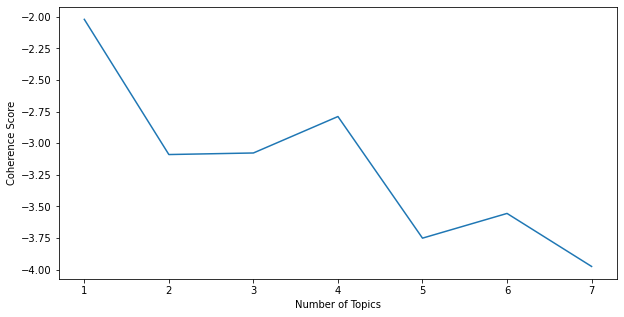

In [20]:
# visualize coherence
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(1,8),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

### Cria os tópicos

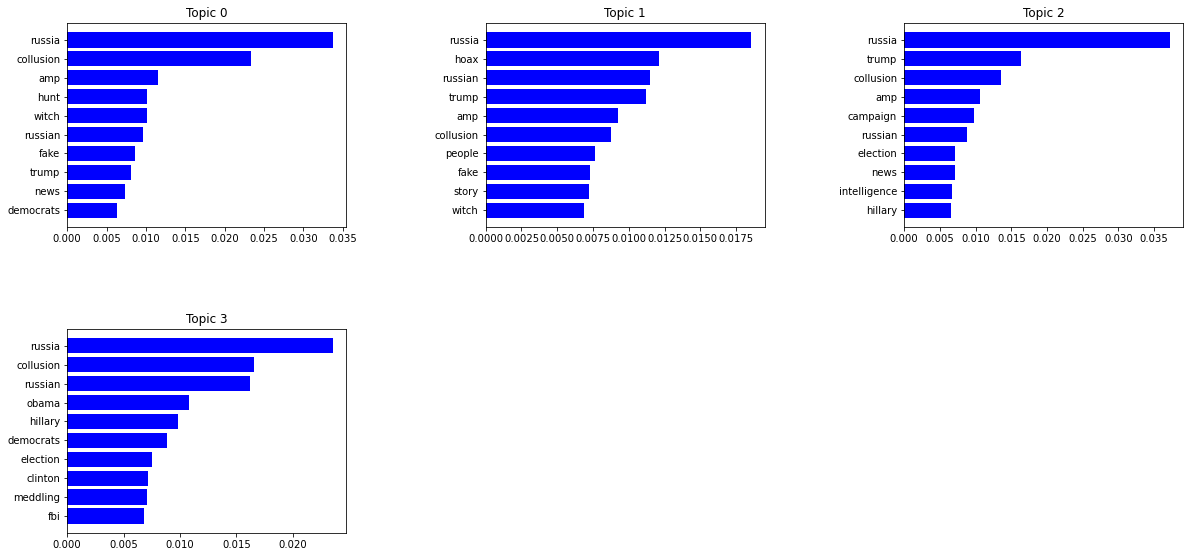

In [21]:
from matplotlib import gridspec

k = 4
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()